# GenTKG

This notebook aims at re-implementing the GenTKG paper.

Preliminary results are:
- GenTKG            validation:     43 / 200    (21 %)
- zrGenTKG-naive    validation:     
    - 12 / 200    (6 %) 
    - 45 / 500    (9 %)  
- zrGenTKG-2.0      validation      
    - 61  / 500    (12 %)


In [1]:
# Automatically reload modules that have changed
%load_ext autoreload
%autoreload 2

# Load environment variables from .env file
%load_ext dotenv
%dotenv


cannot find .env file


### 0.1 Understanding the data


In [2]:
import os
import sys
import pandas as pd

# Add the parent directory to the path. This is necessary to be able to import the modules in the parent directory.
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

c:\Users\Johan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Refernce the data
DATA_DIR = "./../data/raw"  # Relative path to this Notebook
DATASET = "ICEWS18"

data_folder = os.path.join(DATA_DIR, DATASET)

assert os.path.exists(data_folder), f"Data folder {data_folder} does not exist"
print(f"Data folder: {data_folder}")

# List the files in the data folder
data_files = os.listdir(data_folder)
print(f"Data files: {data_files}")

Data folder: ./../data/raw\ICEWS18
Data files: ['entity2id.json', 'entity2id.txt', 'get_history_graph.py', 'relation2id.json', 'relation2id.txt', 'stat.txt', 'test.txt', 'test_lexical.txt', 'train.txt', 'train_lexical.txt', 'ts2id.json', 'valid.txt', 'valid_lexical.txt']


Import train, val and test data


In [4]:
def load_trainvaltest_data(type: str) -> pd.DataFrame:
    _VALID_TYPES = ["train", "valid", "test"]
    assert type in _VALID_TYPES, f"Invalid type {type}. Valid types are {_VALID_TYPES}"

    df = pd.read_csv(
        os.path.join(data_folder, f"{type}.txt"),
        sep="\t",
        dtype=pd.Int16Dtype(),
        dtype_backend="pyarrow",
    )
    df.columns = ["subject_id", "relation_id", "object_id", "timestamp", "_"]
    df = df.drop(columns=["_"])
    return df

# Load the data
df_train = load_trainvaltest_data("train")
df_valid = load_trainvaltest_data("valid")
df_test = load_trainvaltest_data("test")

train_val_split = len(df_valid) / (len(df_valid) + len(df_train))
print(
    f"Train samples: {len(df_train)}, Valid samples: {len(df_valid)} ({round(train_val_split, 2)} %), Test samples: {len(df_test)}"
)

Train samples: 373017, Valid samples: 45994 (0.11 %), Test samples: 49544


Import the decoders


In [5]:
# IMPORT THE DECODERS
# Relation2id
df_relation2id = pd.read_csv(
    os.path.join(data_folder, "relation2id.txt"),
    sep="\t",
    header=None,
    dtype_backend="pyarrow",
)
df_relation2id.columns = ["relation", "relation_id"]
df_relation2id = df_relation2id.astype({"relation_id": pd.Int16Dtype()})

# Entity2id
df_entity2id = pd.read_csv(
    os.path.join(data_folder, "entity2id.txt"),
    sep="\t",
    header=None,
    dtype_backend="pyarrow",
)
df_entity2id.columns = ["entity", "entity_id"]
df_entity2id = df_entity2id.astype({"entity_id": pd.Int16Dtype()})

print(f"Relation2id: {df_relation2id.shape}, Entity2id: {df_entity2id.shape}")
print(df_relation2id.head())
print(df_entity2id.head())

Relation2id: (256, 2), Entity2id: (23033, 2)
                          relation  relation_id
0                   Make statement            0
1        Make an appeal or request            1
2  Use conventional military force            2
3         Rally opposition against            3
4                           Demand            4
                           entity  entity_id
0                     Kim Jong-Un          0
1                     North Korea          1
2   Media Personnel (Afghanistan)          2
3             Media (Afghanistan)          3
4  Islamic Preacher (Afghanistan)          4


Sample a few data points


In [6]:
def decode_data(
    df: pd.DataFrame, relation_decoder: pd.DataFrame, entity_decoder: pd.DataFrame
) -> pd.DataFrame:
    """
    Decodes the data by merging the entity and relation ids with their respective names.
    """
    df_decoded = (
        df.merge(
            entity_decoder.rename(columns={"entity": "subject"}),
            left_on="subject_id",
            right_on="entity_id",
        )
        .drop(columns=["entity_id"])
        .merge(relation_decoder, on="relation_id")
        .merge(
            entity_decoder.rename(columns={"entity": "object"}),
            left_on="object_id",
            right_on="entity_id",
        )
        .drop(columns=["entity_id"])
    )
    return df_decoded


def explain_event(df: pd.DataFrame, idx: int):
    """
    Explains the event at the given index.
    """
    row = df.iloc[idx]
    print_string = f"At timestamp '{row['timestamp']}', '{row['subject']}' '{row['relation']}' '{row['object']}'"
    print(print_string)


df_train_decoded = decode_data(df_train, df_relation2id, df_entity2id)
print(df_train_decoded.head())

# Explain an event
explain_event(df_train_decoded, 0)
explain_event(df_train_decoded, 10)
explain_event(df_train_decoded, 100)

   subject_id  relation_id  object_id  timestamp  \
0           2            0          3          0   
1           4            1          5          0   
2           6            0          7          0   
3           8            2          9          0   
4          10            1          8          0   

                          subject                         relation  \
0   Media Personnel (Afghanistan)                   Make statement   
1  Islamic Preacher (Afghanistan)        Make an appeal or request   
2                  United Nations                   Make statement   
3            Police (Philippines)  Use conventional military force   
4      Philippine National Police        Make an appeal or request   

                  object  
0    Media (Afghanistan)  
1  Citizen (Afghanistan)  
2     Military (Myanmar)  
3  Citizen (Philippines)  
4   Police (Philippines)  
At timestamp '0', 'Media Personnel (Afghanistan)' 'Make statement' 'Media (Afghanistan)'
At timestamp '0

At this stage, it would be interesting to better understand how relations are distributed. For example, is one relation dominating the dataset? Is particular entities dominating specific relations?


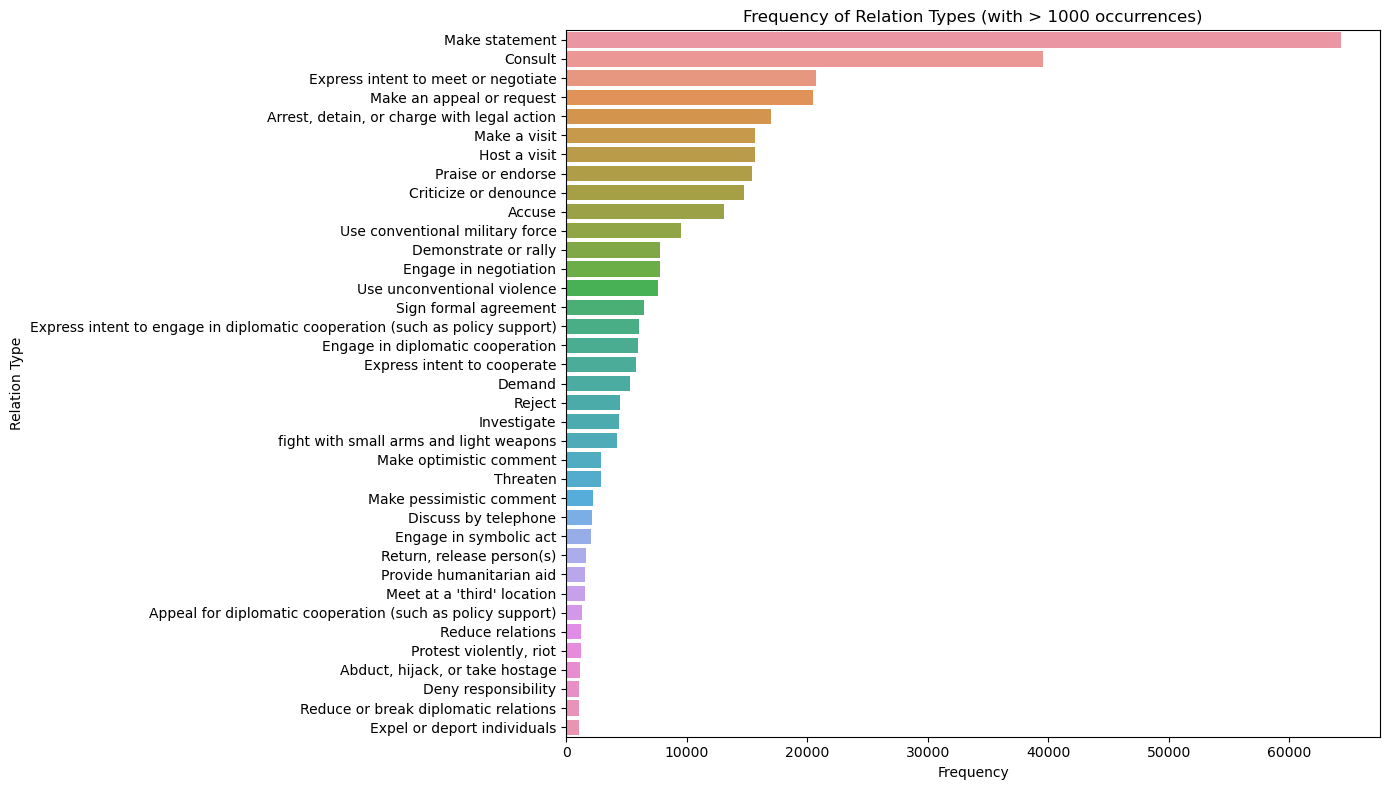

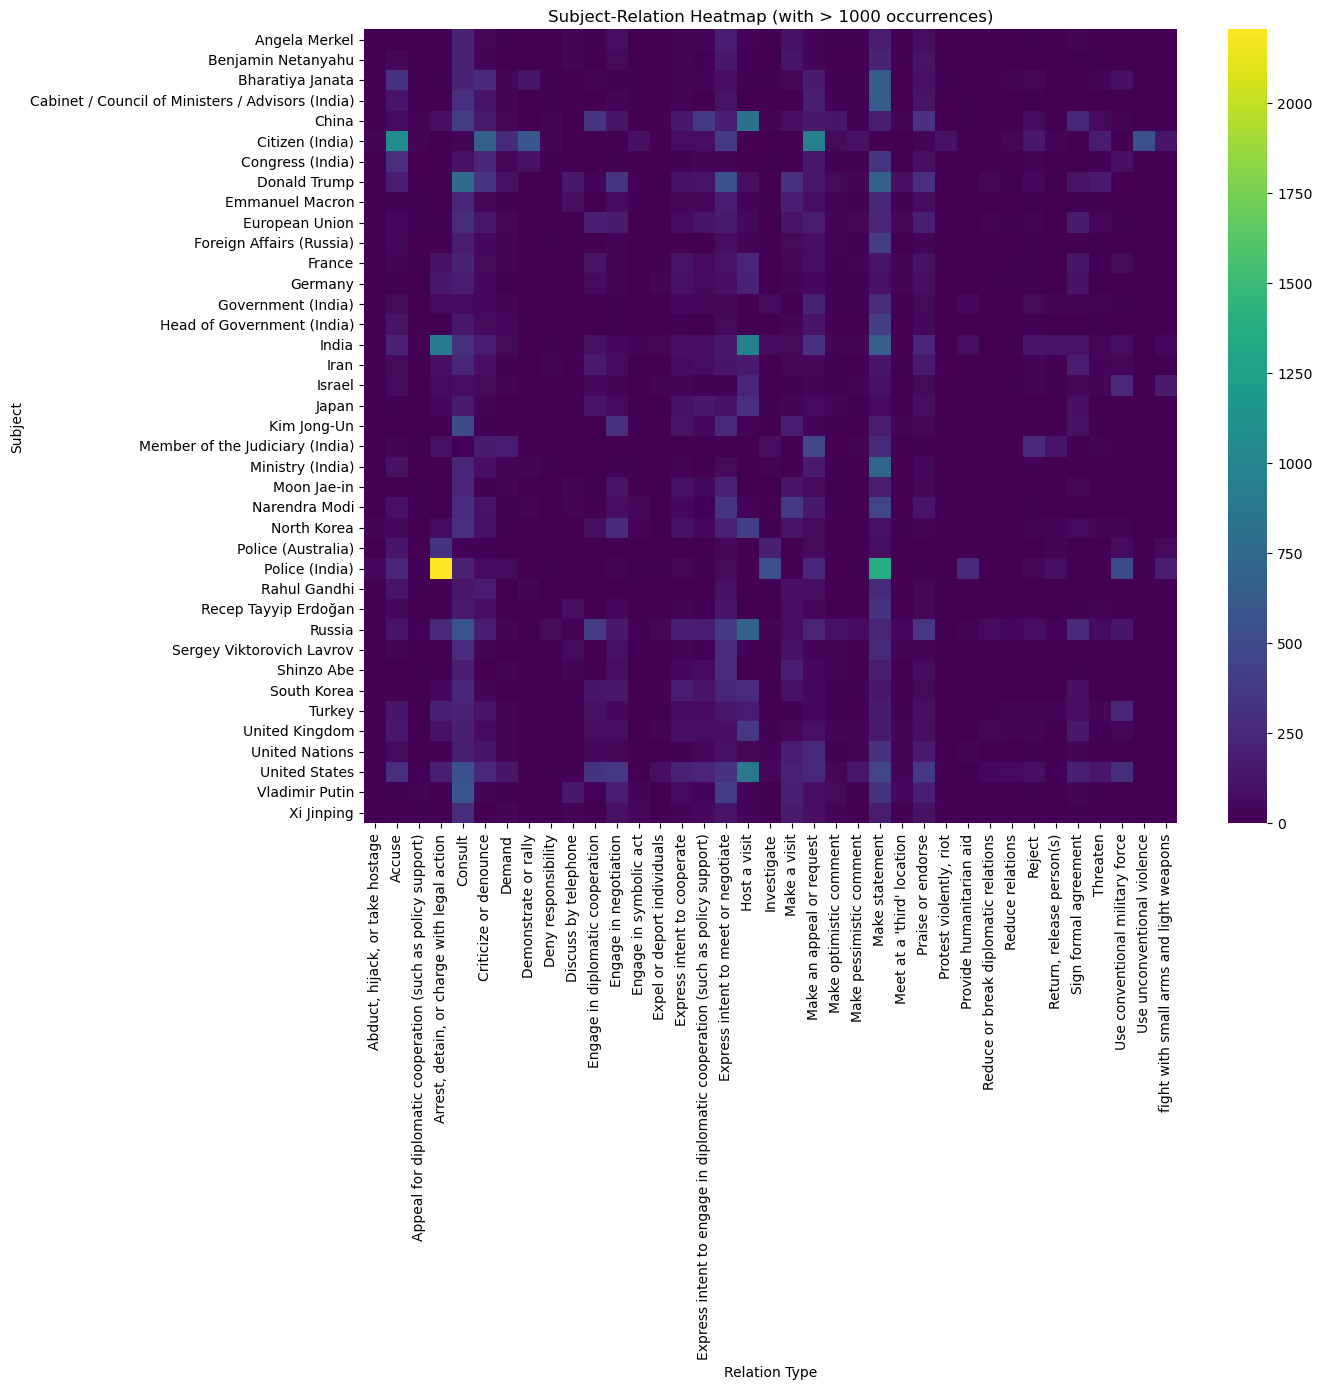

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


def plot_relation_frequency(df):
    """Plot the frequency of relation types with improved label readability."""
    plt.figure(figsize=(14, 8))  # Increase figure size
    relation_counts = df["relation"].value_counts()
    relation_counts = relation_counts[
        relation_counts > 1_000
    ]  # Filter out low-frequency relations

    sns.barplot(x=relation_counts.values, y=relation_counts.index)
    plt.title("Frequency of Relation Types (with > 1000 occurrences)")
    plt.xlabel("Frequency")
    plt.ylabel("Relation Type")
    plt.tight_layout()
    plt.show()


def plot_subject_relation_heatmap(df):
    """Create a heatmap for subject-relation combinations."""
    plt.figure(figsize=(14, 14))  # Increase figure size

    relation_counts = df["relation"].value_counts()
    relation_counts = relation_counts[
        relation_counts > 1_000
    ]  # Filter out low-frequency relations

    subject_relation_counts = (
        df.query(f"relation in {relation_counts.index.tolist()}")
        .groupby(["subject", "relation"])
        .size()
        .unstack(fill_value=0)
    )
    # only keep subjects with more than 10 relations
    subject_relation_counts = subject_relation_counts[
        subject_relation_counts.sum(axis=1) > 1000
    ]
    sns.heatmap(subject_relation_counts, cmap="viridis")

    plt.title("Subject-Relation Heatmap (with > 1000 occurrences)")
    plt.xlabel("Relation Type")
    plt.ylabel("Subject")
    plt.tight_layout()
    plt.show()


plot_relation_frequency(df_train_decoded)
plot_subject_relation_heatmap(df_train_decoded)

### 0.2 GenTKG - Mining Temporal Rules


**Rule Retrieval**


The GenTKGFactsRetriever retriever is the one that was implemented in the GenTKG paper


###

In [8]:

!python ../src/GenTKG/rules_learning/id_words.py --file_to_convert ../data/raw/ICEWS18/train.txt --path_output ../data/raw/ICEWS18/train_lexical.txt --dataset ICEWS18 --period 1
!python ../src/GenTKG/rules_learning/id_words.py --file_to_convert ../data/raw/ICEWS18/valid.txt --path_output ../data/raw/ICEWS18/valid_lexical.txt --dataset ICEWS18 --period 1
!python ../src/GenTKG/rules_learning/id_words.py --file_to_convert ../data/raw/ICEWS18/test.txt --path_output ../data/raw/ICEWS18/test_lexical.txt --dataset ICEWS18 --period 1


In [20]:
!python ../src/GenTKG/rules_learning/learn.py -d ICEWS18 -l 1 -n 200 -p 15 -s 12

Grapher initialized.
Timestamps: [5160, 5112], Temporal Deltas: [-48]
Timestamps: [4056, 4032], Temporal Deltas: [-24]
Timestamps: [1656, 1248], Temporal Deltas: [-408]
Timestamps: [2760, 2544], Temporal Deltas: [-216]
Timestamps: [4920, 4896], Temporal Deltas: [-24]
Timestamps: [1992, 1368], Temporal Deltas: [-624]
Timestamps: [5232, 2184], Temporal Deltas: [-3048]
Timestamps: [4752, 4728], Temporal Deltas: [-24]
Timestamps: [4152, 3864], Temporal Deltas: [-288]
Timestamps: [2856, 2832], Temporal Deltas: [-24]
Timestamps: [2400, 2280], Temporal Deltas: [-120]
Timestamps: [5064, 5040], Temporal Deltas: [-24]
Timestamps: [2736, 2232], Temporal Deltas: [-504]
Timestamps: [3336, 3120], Temporal Deltas: [-216]
Timestamps: [1416, 768], Temporal Deltas: [-648]
Timestamps: [4392, 3216], Temporal Deltas: [-1176]
Timestamps: [1392, 1368], Temporal Deltas: [-24]
Timestamps: [2568, 240], Temporal Deltas: [-2328]
Timestamps: [3888, 3864], Temporal Deltas: [-24]
Timestamps: [3816, 3744], Temporal D

In [24]:
import json
import re
import numpy as np

with open('../cache/071024143421_r[1]_n200_exp_s12_rules.json', 'r') as file:
    learn_data = json.load(file)

#initialize our format
converted_data = {
    "relation_id_head": {},
    "relation_id_body": {},
    "temporal_delta": {},
    "confidence": {},
}

index = 0
for rule in learn_data:
    head_rel = int(rule["head_rel"])
    body_rels = [int(rel) for rel in rule["body_rels"]]
    conf = float(rule["conf"])
    temporal_delta = int(np.abs(int(rule["temporal_deltas"][0])))

    converted_data["relation_id_head"][str(index)] = [head_rel]
    converted_data["relation_id_body"][str(index)] = body_rels
    converted_data["temporal_delta"][str(index)] = temporal_delta
    converted_data["confidence"][str(index)] = conf

    index += 1

with open('../cache/converted_temporal_rules.json', 'w') as file:
    json.dump(converted_data, file, indent=2, separators=(",", ": "))

with open('../cache/converted_temporal_rules.json', 'r') as file:
    json_content = file.read()

json_content = re.sub(r'\[\s*(\d+)\s*\]', r'[\1]', json_content)

with open('../cache/converted_temporal_rules.json', 'w') as file:
    file.write(json_content)


###

In [26]:

#from project.src.GenTKG.learners.simple_learner import SimpleLearner
from src.GenTKG.learners.simple_learner import SimpleLearner
cache_path = "../cache/converted_temporal_rules.json"
#cache_path = "./../cache/temporal_rules_1.json"
learner = SimpleLearner(
    training_data=df_train_decoded,
    cache_path=cache_path,
)
learner.learn()

Temporal rules loaded from cache: ../cache/converted_temporal_rules.json


In [27]:
#from project.src.GenTKG.models import TKGQuery
#from project.src.GenTKG.retrievers.gen_tkg_retriever import GenTKGFactsRetriever

from src.GenTKG.models import TKGQuery
from src.GenTKG.retrievers.gen_tkg_retriever import GenTKGFactsRetriever

gentkg_retriever = GenTKGFactsRetriever(
    w=24 * 30,
    N=50,
    retrieval_data=df_train_decoded,
    learner=learner,
)

facts_test = gentkg_retriever.retrieve_facts(
    TKGQuery(
        timestamp=24 * 30 * 3,
        subject_id=6,
        subject="Abdulrahman",
        relation_id=1,
        relation="Make an appeal or request",
    ),
    verbose=True,
)

Retrieved 267 facts in the time window.
Retrieved 24 facts based on the rule head.
Found 42 relevant temporal rules to the head.
Retrieved 26 facts based on the rule body.


c:\Users\Johan\Documents\DD2430_project\DD2430-project\project\src\GenTKG\retrievers\gen_tkg_retriever.py:79: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_queryset = self.retrieval_data.query(
c:\Users\Johan\Documents\DD2430_project\DD2430-project\project\src\GenTKG\retrievers\gen_tkg_retriever.py:88: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_queryset.query(f"relation_id == {query.relation_id}")
c:\Users\Johan\Documents\DD2430_project\DD2430-project\project\src\GenTKG\retrievers\gen_tkg_retriever.py:115: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_queryset.query(f"relation_id != {query.relation_id}"),


### 0.3 Try some queries


Define supporting classes, e.g LLMs


In [13]:
from typing import List
from openai import OpenAI
import re

#from project.src.GenTKG.models import TKGFact
#from project.src.GenTKG.retrievers.interface import IFactsRetriever

from src.GenTKG.models import TKGFact
from src.GenTKG.retrievers.interface import IFactsRetriever
INSTRUCTION = """
You must be able to correctly predict the next {object_label} from a given text consisting of multiple quadruplets in the form of "[{time}]:[{subject}, {relation}, {object_label}.{object}]" and the query in the form of "[{time}]:[{subject}, {relation}," in the end. The quadruples represents the historical events leading up to today. You must generate only the single number for {object_label} without any explanation.
"""
MODEL = "gpt-4o-mini"


class GenTKGModel:
    def __init__(
        self,
        api_key: str,
        model: str,
        instructions: str = INSTRUCTION,
        retriever: IFactsRetriever = None,
    ):
        self.model = model
        self.instructions = instructions
        self.retriever = retriever

        self.client = OpenAI(api_key=api_key)

    # We can now use the client to interact with the OpenAI API
    def prompt(self, query: TKGQuery, verbose: bool = False) -> int:

        facts = self.retriever.retrieve_facts(query)
        latest_time = query.timestamp

        # formatted_rules = "\n".join([str(rule) for rule in rules])
        formatted_history = "\n".join(
            [fact.to_relative_string(latest_time) for fact in facts]
        )
        # formatted_query = str(query)
        formatted_query = query.to_relative_string(latest_time)
        input = f"{formatted_history}\n{formatted_query}"

        if verbose:
            print(f"Input: {input} \n --------")

        response = self.client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": self.instructions,
                },
                {
                    "role": "user",
                    "content": input,
                },
            ],
            model=self.model,
        )
        object_id_str = response.choices[0].message.content

        if verbose:
            print(f"Output: {object_id_str}")

        try:
            object_id = int(re.findall(r"\d+", object_id_str)[0])
        except IndexError:
            print(f"Error: Could not convert '{object_id_str}' to integer")
            object_id = None

        return object_id

Instantiate retreivers


In [14]:
# Instantiate retrievers
#from project.src.GenTKG.retrievers.example_fact_retriever import ExampleFactsRetriever
#from project.src.GenTKG.retrievers.naive_facts_retriever import NaiveFactsRetriever
from src.GenTKG.retrievers.example_fact_retriever import ExampleFactsRetriever
from src.GenTKG.retrievers.naive_facts_retriever import NaiveFactsRetriever

example_facts_retriever = ExampleFactsRetriever()
naive_facts_retriever = NaiveFactsRetriever(
    training_data=df_train_decoded, w=24 * 365, N=50
)
cache_path = "./../cache/temporal_rules_1.json"
gentkg_retriever = GenTKGFactsRetriever(
    w=24 * 30,
    N=50,
    retrieval_data=df_train_decoded,
    learner=learner,
)

In [15]:
query = TKGQuery(
    timestamp=5040,
    subject_id=1823,
    subject="Rami Abdulrahman",
    relation_id=8,
    relation="Praise or endorse",
)

# Now give it a try with the paper's example
instructions_modified = (
    INSTRUCTION
    + "\n One row below, rank your 2, and 3 answers in order of likelihood."
    + "\n One row below, motivate WHY you chose this answer. The text is aimed for executive decision makers. Answer in natural language, for example: 'Given the recent events {examples}, it is likely that {object_label} ...'. The object label can be derived from the historical data."
)
print(instructions_modified)

model = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever,
)

output_id = model.prompt(query, verbose=True)


You must be able to correctly predict the next {object_label} from a given text consisting of multiple quadruplets in the form of "[{time}]:[{subject}, {relation}, {object_label}.{object}]" and the query in the form of "[{time}]:[{subject}, {relation}," in the end. The quadruples represents the historical events leading up to today. You must generate only the single number for {object_label} without any explanation.

 One row below, rank your 2, and 3 answers in order of likelihood.
 One row below, motivate WHY you chose this answer. The text is aimed for executive decision makers. Answer in natural language, for example: 'Given the recent events {examples}, it is likely that {object_label} ...'. The object label can be derived from the historical data.


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

### 0.4 Test the setup


In [13]:
from typing import Tuple


df_valid_decoded = decode_data(df_valid, df_relation2id, df_entity2id)


def sample_query(df_decoded: pd.DataFrame) -> Tuple[TKGQuery, List[TKGFact]]:
    """
    Samples a random query from the decoded DataFrame.

    Parameters:
    - df_decoded: The decoded DataFrame. Must contain columns 'timestamp', 'subject_id', 'subject', 'relation_id', 'relation'

    Returns:
    - TKGQuery: The sampled query
    - TKGFact[]: The corresponding facts with the same subject, relation and time. Predicting anyone of these facts is considered correct.
    """
    row = df_decoded.sample(1).iloc[0]
    query = TKGQuery(
        timestamp=row["timestamp"],
        subject_id=row["subject_id"],
        subject=row["subject"],
        relation_id=row["relation_id"],
        relation=row["relation"],
    )

    subject_id = query.subject_id
    relation_id = query.relation_id
    timestamp = query.timestamp

    # Get the facts at the timestamp
    df_correct_facts = df_decoded.query(
        f"timestamp == {timestamp} and subject_id == {subject_id} and relation_id == {relation_id}"
    ).to_dict(orient="records")

    facts = [
        TKGFact(
            timestamp=row["timestamp"],
            subject=row["subject"],
            relation=row["relation"],
            object=row["object"],
            object_id=row["object_id"],
        )
        for row in df_correct_facts
    ]

    return query, facts


query, facts = sample_query(df_train_decoded)
print("QUERY:", query)
print("FACTS:", facts)

QUERY: 5232:[UN General Assembly, Praise or endorse,
FACTS: [TKGFact(timestamp=5232, subject='UN General Assembly', relation='Praise or endorse', object='China', object_id=50)]


Test the predictions


In [14]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Callable


def label_is_inn_supporting_facts(
    supporting_facts: List[TKGFact], facts: List[TKGFact]
):
    supporting_fact_object_ids = [fact.object_id for fact in supporting_facts]
    correct_object_ids = [fact.object_id for fact in facts]

    possible = any(
        output_id in correct_object_ids for output_id in supporting_fact_object_ids
    )

    if not possible:
        print(
            f"Warning: The supporting facts ({len(supporting_facts)}) do not contain any true object_ids {correct_object_ids}. The model could not have been correct for the query on fact {facts}."
        )
        return False

    return True


def evaluate_one_sample(model: GenTKGModel, data_generator: Callable) -> bool:
    query, facts = data_generator()

    output_id = model.prompt(query, verbose=True)

    correct_object_ids = [fact.object_id for fact in facts]

    correct = output_id in correct_object_ids
    print(
        f"- Correct? {correct}, Output ID: {output_id}, Correct IDs: {correct_object_ids}"
    )

    return correct  # Return boolean value


def evaluate_model_async(model: GenTKGModel, data_generator: Callable, n: int = 10):
    print(f"Running {n} samples")

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                evaluate_one_sample,
                model,
                data_generator,
            )
            for _ in range(n)
        ]

        results = []
        for future in as_completed(futures):
            try:
                result = future.result()  # Get the result of the evaluation
                results.append(result)
            except Exception as e:
                print(f"Error occurred: {e}")

    print(f"Accuracy: {sum(results)}/{n}")  # Ensure sum results are boolean values


# The retrieval data is the training and validation data combined, which is where the retriever will look for facts.
df_trainval_decoded = (
    pd.concat([df_train_decoded, df_valid_decoded], axis=0)
    .reset_index(drop=True)
    .sort_values("timestamp", ascending=True)
)
# Remove entites that only exists in the test set
df_trainval_decoded = df_trainval_decoded[
    df_trainval_decoded["subject_id"].isin(df_test["subject_id"])
    | df_trainval_decoded["object_id"].isin(df_test["object_id"])
]

# Setup everything and run!
learner = SimpleLearner(
    training_data=df_trainval_decoded,
    cache_path=cache_path,
)
gentkg_retriever_validation = GenTKGFactsRetriever(
    w=24 * 30,
    N=50,
    retrieval_data=df_trainval_decoded,
    learner=learner,
)
# Instantiate the retriever and model as before
model = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever_validation,
)
data_generator = lambda: sample_query(df_trainval_decoded)

# Run the evaluation in parallel
evaluate_model_async(model, data_generator, n=1)

Attempting to get_rules without learning first. Learning now...
Temporal rules loaded from cache: ./../cache/temporal_rules_1.json
Running 1 samples
Input: [30 days ago]:[Farm Worker (India), Make an appeal or request, 70:Government (India)]
[30 days ago]:[Farm Worker (India), Demonstrate or rally, 57:Unspecified Actor]
[30 days ago]:[Farm Worker (India), Demonstrate or rally, 122:India]
[29 days ago]:[Farm Worker (India), Make an appeal or request, 70:Government (India)]
[29 days ago]:[Farm Worker (India), Engage in symbolic act, 170:Other Authorities / Officials (India)]
[28 days ago]:[Farm Worker (India), Demonstrate or rally, 57:Unspecified Actor]
[27 days ago]:[Farm Worker (India), Consult, 406:Cabinet / Council of Ministers / Advisors (India)]
[27 days ago]:[Farm Worker (India), Make an appeal or request, 170:Other Authorities / Officials (India)]
[21 days ago]:[Farm Worker (India), Host a visit, 221:Benjamin Netanyahu]
[21 days ago]:[Farm Worker (India), Make an appeal or reques

## 0.5 Explore zero-shot relations

To improve our model to handle zero-shot relations, we want to evaluate how well the model is able to predict what happens on relations it hasn't seen before.

This is achieved by hiding categories from the training data, and let the model predict those samples only during the evaluation. One can choose to either hide relations or objects. Previous papers (e.g. zrLLM) hid relations which we'll do here as well. It makes the most sense.

**Plan**
1. First we will decide on which relations to hide.
2. Omit these from the training data.
3. Learn the rules like before, but this time with the altered training data.
4. Perform the evaluation, but query only on zero-shot relations.

In [15]:
# Now, entities that exist in the training data but not in the validation data
# is fine. However, entities that exist in the validation data but not in the training data
# is not fine, as the model has not seen these entities before.


def check_entities_relations_exist(
    training: pd.DataFrame, validation: pd.DataFrame
) -> None:
    training_entities = set(
        [*training["subject_id"].unique(), *training["object_id"].unique()]
    )
    validation_entities = set(
        [*validation["subject_id"].unique(), *validation["object_id"].unique()]
    )

    training_relations = set(training["relation_id"].unique())
    validation_relations = set(validation["relation_id"].unique())

    missing_entities = validation_entities - training_entities
    missing_relations = validation_relations - training_relations

    print(f"Missing entities ({len(missing_entities)}): {missing_entities}")
    print(f"Missing relations ({len(missing_relations)}): {missing_relations}")


# check_entities_relations_exist(df_train_decoded, df_valid_decoded)

**[1] Hide relations**

In zrLLM, they drew a threshold of relation frequency, and all relations with less than that became zero-shot.

Number of zero-shot relations: 127 / 251 (50.6 %)
Number of rows left after removing zero-shot relations: 369628 (99.09 %)


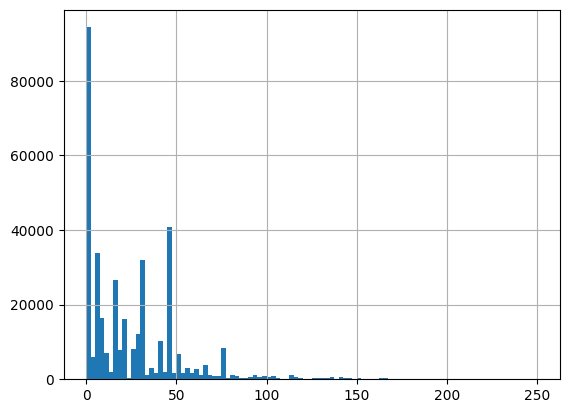

In [16]:
THRESHOLD = 100  # Set a threshold for the number of occurrences


# Plot the distribution of relation types
df_train_decoded.relation_id.hist(bins=100)

df_training_relation_freq = (
    df_train_decoded.groupby("relation_id").size().sort_values(ascending=False)
)
df_zero_shot_relations = df_training_relation_freq[
    df_training_relation_freq < THRESHOLD
]

# Filter out relations with less than the threshold
n_zero_shot_relations = df_zero_shot_relations.count()
total_relations = len(df_training_relation_freq)
zero_shot_percentage = round(n_zero_shot_relations / total_relations * 100, 2)
print(
    f"Number of zero-shot relations: {n_zero_shot_relations} / {len(df_training_relation_freq)} ({zero_shot_percentage} %)"
)

n_rows_left_after_zr_filter = len(
    df_train_decoded.query("relation_id not in @df_zero_shot_relations.index")
)
rows_left_percentage = round(
    n_rows_left_after_zr_filter / len(df_train_decoded) * 100, 2
)
print(
    f"Number of rows left after removing zero-shot relations: {n_rows_left_after_zr_filter} ({rows_left_percentage} %)"
)

In [17]:
print("Zero shot relations:")
df_train_decoded[
    df_train_decoded["relation_id"].isin(df_zero_shot_relations.index)
].relation.unique()

Zero shot relations:


<ArrowExtensionArray>
[                                         'Appeal for policy change',
                                                 'Expel or withdraw',
                                                 'Violate ceasefire',
                                       'Reduce or stop material aid',
                                    'Threaten to reduce or stop aid',
                                          'Threaten with repression',
                               'Express intent to change leadership',
                                          'Seize or damage property',
                                          'Return, release property',
                                               'Use as human shield',
 ...
                                                'Receive inspectors',
                 'Reject request for change in institutions, regime',
                                       'Demand economic cooperation',
                                          'Engage in mass expul

**[2] Omit these from the training data**



In [18]:
df_train_decoded_zr_not = df_train_decoded.query(
    "relation_id not in @df_zero_shot_relations.index"
)

assert len(df_train_decoded_zr_not) > 0, "No zero-shot relations found"
n_total_relations = len(df_train_decoded["relation_id"].unique())
assert df_train_decoded_zr_not["relation_id"].nunique() == (
    n_total_relations - n_zero_shot_relations
)

n_total_rows_after_zr = len(df_train_decoded_zr_not)
print(
    f"Total rows after removing zero-shot relations: {n_total_rows_after_zr} (before: {len(df_train_decoded)})"
)

Total rows after removing zero-shot relations: 369628 (before: 373017)


**[3] Learn the temporal rules wrt zero-shot**

In [19]:
cache_path_zr = "./../cache/temporal_rules_zero_shot.json"

learner_zr = SimpleLearner(
    training_data=df_train_decoded_zr_not,
    cache_path=cache_path_zr,
)

gentkg_retriever_zr = GenTKGFactsRetriever(
    w=24 * 30,
    N=50,
    retrieval_data=df_trainval_decoded,
    learner=learner_zr,
)

Attempting to get_rules without learning first. Learning now...
Temporal rules loaded from cache: ./../cache/temporal_rules_zero_shot.json


**[4a] Perform the zero-shot evaluation - NAIVELY**

In [20]:
# Now, we must filter the validation data to only contain zero-shot relations
df_valid_decoded_zr_only = df_valid_decoded.query(
    "relation_id in @df_zero_shot_relations.index"
)

In [28]:
# Instantiate the retriever and model as before
model = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever_zr,
)

# This time, the data generator only samples from the zero-shot relations
data_generator_zr = lambda: sample_query(df_valid_decoded_zr_only)
# Run the evaluation in parallel
evaluate_model_async(model, data_generator_zr, n=1)

Running 500 samples
Input: 
[now]:[Moon Jae-in, Demand meeting, negotiation, 
 --------
Input: 
[now]:[Party Member (Switzerland), Express intent to change leadership, 
 --------
Input: 
[now]:[António Manuel de Oliveira Guterres, Demand de-escalation of military engagement, 
 --------
Input: 
[now]:[Edwin Clark, Forgive, 
 --------
Input: 
[now]:[Amnesty International, Accuse of war crimes, 
 --------
Input: 
[now]:[Ferdinand Marcos, Appeal for easing of administrative sanctions, 
 --------
Input: 
[now]:[Pauline Hanson, Appeal for rights, 
 --------
Input: 
[now]:[Ecuador, Appeal for humanitarian aid, 
 --------
Input: 
[now]:[Senate (Philippines), Impose state of emergency or martial law, 
 --------
Input: 
[now]:[European Union, Refuse to ease economic sanctions, boycott, or embargo, 
 --------
Input: 
[now]:[Saudi Arabia, Threaten to reduce or break relations, 
 --------
Input: 
[now]:[António Manuel de Oliveira Guterres, Appeal to others to settle dispute, 
 --------
Input: 
[now

As can be seen, the model is only able to fetch facts which has the zero-shot relation. It is not able to fetch any other facts, simply because it hasn't learnt any rules for that. There probably are a lot of rules that are applicable, but the model has no way of knowing what to use.

**[4b] Perform the zero-shot evaluation - EXTENDED**

Now, it's time to actually extend our model to handle zero-shot relations. To do that we need to fill our vector store.

In [29]:
from project.src.GenTKG.vectorstore import SimpleVectorstore

cache_path_vector_store = "./../cache/vectorstore.json"

vectorstore = SimpleVectorstore(
    cache_path=cache_path_vector_store,
    openai_api_key=os.environ.get("OPENAI_API_KEY"),
)

all_relations = df_train_decoded["relation"].unique()
vectorstore.insert(all_relations)

vectorstore.update_cache()

No new relations to insert


In [30]:
# Exapmle of how to retrieve vectors
relation_zero_shot = "Nuke the hell out of"
similar_relations = vectorstore.get_topk_similar(relation_zero_shot, k=3)

print(f"Similar relations to '{relation_zero_shot}': {similar_relations}")

Similar relations to 'Nuke the hell out of': ['Detonate nuclear weapons', 'Use weapons of mass destruction', 'Carry out car bombing']


In [32]:
from project.src.GenTKG.retrievers.gen_tkg_zr_retriever import (
    GenTKGZeroShotFactsRetriever,
)

gentkg_retriever_validation_zr_similarity = GenTKGZeroShotFactsRetriever(
    w=24 * 30,
    N=50,
    retrieval_data=df_trainval_decoded,
    learner=learner_zr,
    vectorstore=vectorstore,
)

In [33]:
# EXAMPLE:
# Here, we create a "fake" query with a completetly unreasonable relation, to see what the retriever returns.

query = TKGQuery(
    timestamp=6458,
    subject_id=13,
    subject="Rodrigo Duterte",
    relation_id=999,
    relation="Wanting to kill",
)

facts_test = gentkg_retriever_validation_zr_similarity.retrieve_facts(query, verbose=True)


Retrieved 133 facts in the time window.
Retrieved 0 facts based on the rule head.
Found 0 relevant temporal rules to the query.
Found 41 top-k similar temporal rules.
Retrieved 50 facts based on the rule body.


Good! Now lets redo the previous zero-shot evaluation

In [ ]:
# Instantiate the retriever and model as before
model = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever_validation_zr_similarity,
)

# This time, the data generator only samples from the zero-shot relations
data_generator_zr = lambda: sample_query(df_valid_decoded_zr_only)
# Run the evaluation in parallel
evaluate_model_async(model, data_generator_zr, n=1)